<a href="https://colab.research.google.com/github/JuanArmas/BigDataSNS/blob/main/Actividad_3_7_Terremotos_Juan_Armas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Actividad_3_7_Predicción de Riesgo de derrumbamiento - Terremotos

#Autor:
Juan Airam Armas Alemán

#Github:
https://github.com/JuanArmas/BigDataSNS/blob/main/Actividad_3_7_Terremotos_Juan_Armas.ipynb
#Drive:
https://drive.google.com/drive/folders/1Jxc5SQ6ImP0X97n1zVE8vFDCV0RHCCa4?usp=sharing


#Entendiendo el problema:
Estamos tratando de predecir la variable ordinal "damage_grade" , que representa un nivel de daño al edificio que fue golpeado por el terremoto. Hay 3 grados de daño:

1 representa un daño bajo
2 representa una cantidad media de daño
3 representa una destrucción casi completa

**Datos Categóricos:**

Estas letras generalmente se refieren a diferentes tipos de cimientos:

- **R**: Es una gran losa de concreto que sostiene toda la estructura.
- **W**: Implica excavar el suelo a una profundidad considerable y construir una estructura similar a un pozo para sostener el edificio, entiendo que son cimientos.
- **I**: Representa una cimentación “Aislada”, donde zapatas individuales sostienen columnas de forma independiente, permitiendo cierto grado de movimiento.
- **U**: Significa cimentación “Subescariada”, que implica ampliar la base de la cimentación para brindar mayor estabilidad.
- **H**: Se refiere a cimientos de “pilotes”, donde columnas verticales (pilotes) se hunden profundamente en el suelo para soportar la estructura.

**Datasets**
- **Valores de entrenamiento:** Son las características que se usará para entrenar un modelo. Hay 38 características, incluyendo información estructural como el número de pisos (antes del terremoto), edad del edificio y tipo de cimientos, así como información legal como el estado de propiedad, el uso del edificio y el número de familias que viven. allá. Cada edificio está identificado por un código único (aleatorio) building_id, que se puede utilizar como índice.

- **Etiquetas de entrenamiento**: ESon las etiquetas. Cada uno building_idde los datos de los valores de entrenamiento tiene una etiqueta correspondiente en este archivo. 1 representa un daño bajo, 2 representa una cantidad media de daño y 3 representa una destrucción casi completa.

- **Valores de prueba:** estas son las funciones que se usará para hacer predicciones después de entrenar un modelo. No le damos las etiquetas para estas muestras, Tengo que generar predicciones del nivel de daño sísmico para estas building_idmuestras

In [14]:
import os
import io
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


#========================
# from sklearn import tree
from sklearn.svm import SVC
from google.colab import drive
from google.colab import files
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.model_selection import train_test_split, KFold,cross_val_score, GridSearchCV ,cross_val_predict,RandomizedSearchCV


# from sklearn.impute import SimpleImputer
# from scipy.stats import randint as sp_randint
# from sklearn.linear_model import LogisticRegression
# from sklearn.utils import shuffle,resample,validation
# from sklearn.tree import plot_tree,DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor,GradientBoostingClassifier
# from sklearn.metrics import confusion_matrix, accuracy_score, mean_absolute_error, mean_squared_error



In [15]:
# Generamos acceso al drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
# Cargamos la información del drive para poder acceder a ella
train_values_path = "/content/drive/MyDrive/Practica_Terremotos/train_values.csv"
test_values_path = "/content/drive/MyDrive/Practica_Terremotos/test_values.csv"
train_labels_path = "/content/drive/MyDrive/Practica_Terremotos/train_labels.csv"

In [17]:
# Establecemos la columna 'building_id' como el índice para los DataFrames resultantes
train_values_df = pd.read_csv(train_values_path, index_col='building_id')
test_values_df = pd.read_csv(test_values_path, index_col='building_id')
train_labels_df = pd.read_csv(train_labels_path, index_col='building_id')

In [ ]:
# train_values_df.head()
# test_values_df.head()
# train_labels_df.head()

In [ ]:
# train_values_df.dtypes
# test_values_df.dtypes
# train_labels_df.dtypes

<Axes: title={'center': 'Cantidad de edificios con El tipo de daño sufrido'}, xlabel='damage_grade'>

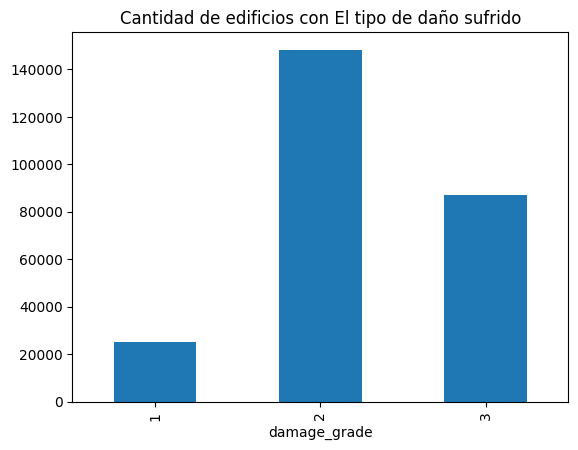

In [18]:
(train_labels_df.damage_grade
             .value_counts()
             .sort_index()
             .plot.bar(title="Cantidad de edificios con El tipo de daño sufrido"))

In [19]:
selected_features = ['foundation_type',
                     'area_percentage',
                     'height_percentage',
                     'count_floors_pre_eq',
                     'land_surface_condition',
                     'has_superstructure_cement_mortar_stone']

X_train_values = train_values_df[selected_features]

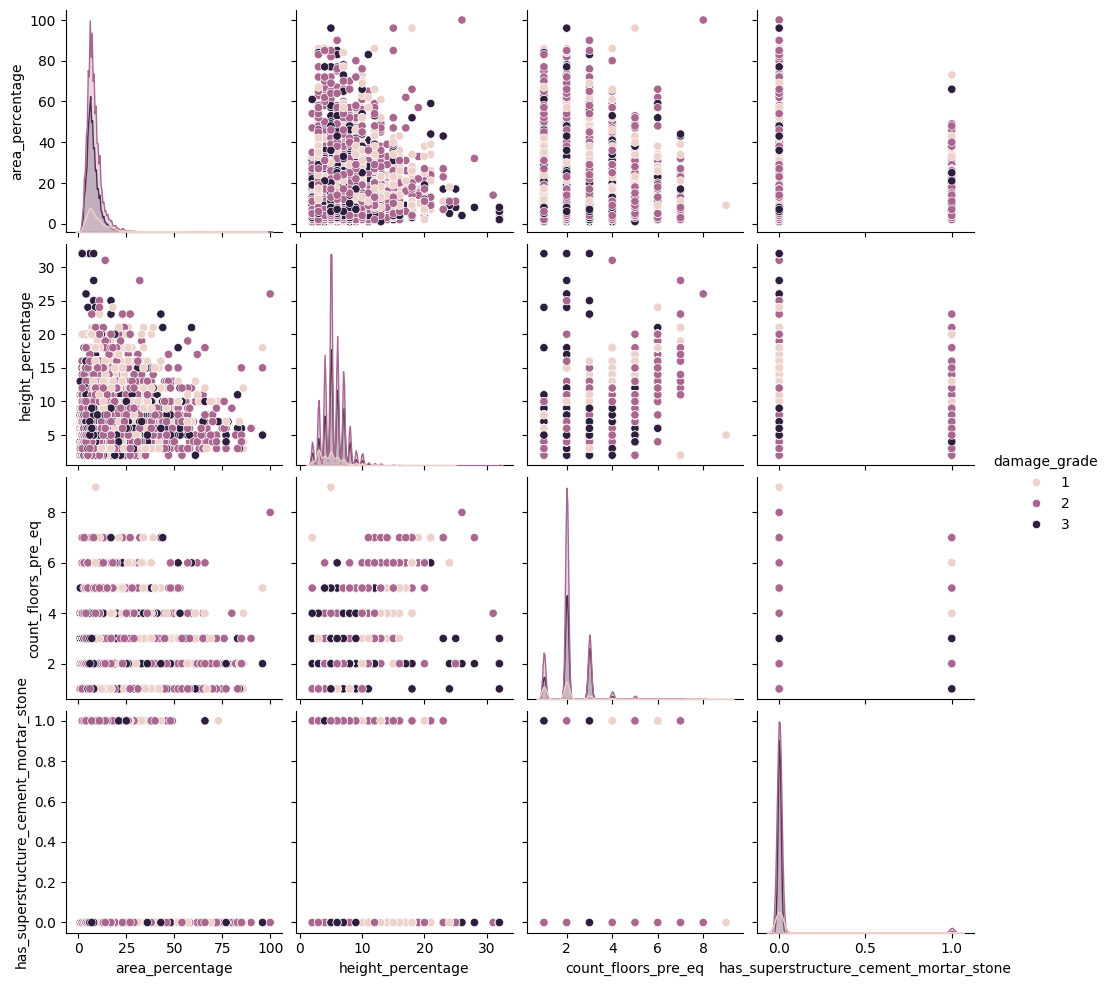

In [12]:
sns.pairplot(X_train_values.join(train_labels_df),
             hue='damage_grade')

In [20]:
X_train_values = pd.get_dummies(X_train_values)

In [21]:
# Seleccionar las características para X_train_values
X_train_values = train_values_df[selected_features]
# Obtener las etiquetas correspondientes a los datos de entrenamiento
y_train_labels = train_labels_df["damage_grade"]

# Dividir el conjunto de entrenamiento en X_train y X_test
X_train, X_test, y_train, y_test = train_test_split(X_train_values, y_train_labels, test_size=0.3, random_state=42)

X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

# Dividir el conjunto de entrenamiento en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)


# One hot encoder

In [22]:
# Selecciona solo las características categóricas para aplicar One-Hot Encoding
categorical_features = ['foundation_type',
                        'land_surface_condition']

# Inicializa el codificador One-Hot
encoder = OneHotEncoder(drop='first', sparse=False)

# Ajustar y transforma los datos de características categóricas para X_train
X_train_encoded = encoder.fit_transform(X_train[categorical_features])

# Transforma los datos de características categóricas para X_val y X_test
X_val_encoded = encoder.transform(X_val[categorical_features])
X_test_encoded = encoder.transform(X_test[categorical_features])

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


#Escalamiento de conjunto de datos

In [23]:
# Inicializamos StandardScaler
scaler = StandardScaler()

# Ajustamos y transformamos los datos de características numéricas para X_train
X_train_scaled = scaler.fit_transform(X_train.drop(columns=categorical_features))

# transformamos los datos de características numéricas para X_val y X_test
X_val_scaled = scaler.transform(X_val.drop(columns=categorical_features))
X_test_scaled = scaler.transform(X_test.drop(columns=categorical_features))

Combinación de características codificadas y escaladas

In [24]:
# Combina las características codificadas y escaladas para el conjunto de entrenamiento
X_train_combined = np.hstack((X_train_encoded, X_train_scaled))
# Combina las características codificadas y escaladas para el conjunto de validación
X_val_combined = np.hstack((X_val_encoded, X_val_scaled))
# Combina las características codificadas y escaladas para el conjunto de prueba
X_test_combined = np.hstack((X_test_encoded, X_test_scaled))

Hacemos un muestreo aleatorio para el dendograma

In [25]:
# Tamaño de la muestra deseada
sample_size = 10000  # Seleccionaremos 3000 filas de entrenamiento de forma aleatoria

# Convertir X_train_combined a DataFrame (si no es DataFrame)
X_train_df = pd.DataFrame(X_train_combined)

# Concatenar X_train_df con y_train para mantener las relaciones entre características y etiquetas
train_data = pd.concat([X_train_df, pd.DataFrame(y_train, columns=['target'])], axis=1)

# Realizar muestreo aleatorio para seleccionar una muestra del conjunto de entrenamiento
sampled_train_data = train_data.sample(n=sample_size, random_state=42)

# Separar las características y las etiquetas de la muestra aleatoria
X_train_sampled = sampled_train_data.drop(columns=['target']).values
y_train_sampled = sampled_train_data['target'].values

# Verificar las dimensiones del conjunto de entrenamiento reducido
print("Dimensiones del conjunto de entrenamiento reducido:", X_train_sampled.shape, y_train_sampled.shape)


Dimensiones del conjunto de entrenamiento reducido: (10000, 10) (10000,)


#Dendograma

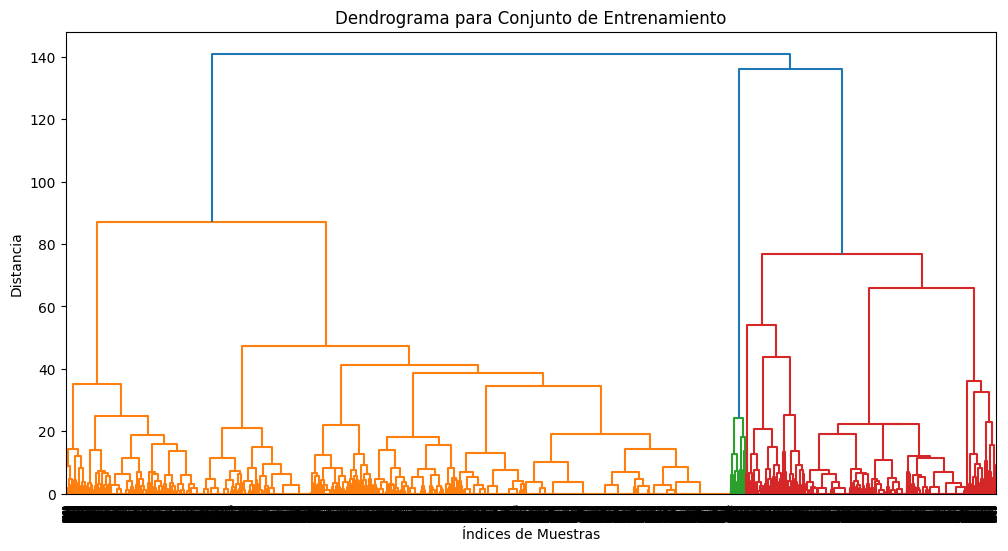

In [26]:
# Calcula la matriz de enlace con los datos reducidos por PCA
Z = linkage(X_train_sampled, method='ward')

# Crea el dendrograma
plt.figure(figsize=(12, 6))
plt.title('Dendrograma para Conjunto de Entrenamiento')
plt.xlabel('Índices de Muestras')
plt.ylabel('Distancia')
dendrogram(Z)
plt.show()

#SelectKBest

In [ ]:
# X_train_combined
# X_val_combined
# X_test_combined

In [11]:
# Inicializa SelectKBest con f_classif como función de puntuación y k=4
selector = SelectKBest(f_classif, k=3)

# Ajusta el selector con los datos de entrenamiento escalados y las etiquetas de entrenamiento
selector.fit(X_train_combined, y_train)

# Obtén las características seleccionadas
selected_indices = selector.get_support(indices=True)
selected_features = [X_train.columns[i] for i in selected_indices]

# Transforma conjuntos de entrenamiento, validación y prueba
X_train_selected = selector.transform(X_train_combined)
X_val_selected = selector.transform(X_val_combined)
X_test_selected = selector.transform(X_test_combined)

# Imprime las características seleccionadas
print("Características seleccionadas:", selected_features)


Características seleccionadas: ['foundation_type', 'height_percentage', 'count_floors_pre_eq']


----------
inicio sin testear

---------
FIN DENDOGRAMA

#Cross Validation
Aplicamos Cross Validation a los conjuntos de datos

In [ ]:
# cv = KFold(n_splits = 10, shuffle = False)
cv = KFold(n_splits = 10, shuffle=True, random_state=42)


for train_fold, test_fold in cv.split(X_train_selected):  # Recorre las particiones
  f_train = X_train.iloc[train_fold]  # Separa datos de entrenamiento para la partición actual
  f_test = X_train.iloc[test_fold]   # Separa datos de prueba para la partición actual

depth_range = range(1, len(df_denge_encoded_features) * 3 + 1) # Definimos un rango de valores para la profundidad máxima que se aplicará a los distintos árboles e hiperparámetros



-------------------------------------
fin sin testear

---------
Inicio testeo modelos y pruebas de hiper-parametrización

# Modelo: SVC

In [ ]:
# Cross Validation

# scores = cross_val_score(svm_model, X_train_selected, y_train, cv=cv)


svm_model = SVC(kernel='linear',probability=True).fit(X_train_selected, y_train)
# Entrenamiento
# svm_model.fit(X_train_selected, y_train)
scores = cross_val_score(svm_model, X_train_selected, y_train, cv=cv)

# Predicciones
predicted_labels_test = svm_model.predict(X_test_selected)

# Métricas
mse = mean_squared_error(y_test, predicted_labels_test)
mae = mean_absolute_error(y_test, predicted_labels_test)

print("Accuracy promedio en la validación cruzada:", np.mean(scores))
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

Accuracy promedio en la validación cruzada: 0.11266233766233766
Mean Squared Error: 75.40503432494279
Mean Absolute Error: 6.34324942791762


# Aplicando gridsearch para la mejora de características

In [ ]:
# Definir los parámetros
param_dist_grdsrch3 = {
    'C': [100, 150, 300, 500],        # Parámetro de regularización
    'gamma': [0.001, 0.01, 0.1, 1], # Parámetro del kernel (para 'rbf')
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']    # Tipo de kernel
}

# Inicializar GridSearchCV
grid_search_svm = GridSearchCV(svm_model, param_dist_grdsrch3, cv=5, scoring='accuracy', verbose=1)

# Ajustar GridSearchCV a los datos
grid_search_svm.fit(X_train_selected, y_train)

# Mostrar los mejores parámetros encontrados y VC
print("Mejores parámetros:", grid_search_svm.best_params_)
print("Mejor puntuación de validación cruzada:", grid_search_svm.best_score_)

# Mejor modelo
best_svm_model = grid_search_svm.best_estimator_

test_accuracy = best_svm_model.score(X_test_selected, y_test)
print("Precisión en el conjunto de prueba:", test_accuracy)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Mejores parámetros: {'C': 500, 'gamma': 0.001, 'kernel': 'linear'}
Mejor puntuación de validación cruzada: 0.8612831097351222
Precisión en el conjunto de prueba: 0.8032036613272311


In [ ]:
# Predicciones
predicted_labels_test = best_svm_model.predict(X_test_selected)

# Error cuadrático medio (MSE)
mse = mean_squared_error(y_test, predicted_labels_test)

# CError absoluto medio (MAE)
mae = mean_absolute_error(y_test, predicted_labels_test)


print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)


Mean Squared Error: 16.137299771167047
Mean Absolute Error: 0.9839816933638444


In [ ]:
svc_param_dist = {
    'C': [300, 450, 500, 1000],  # Parámetro de regularización
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Tipo de kernel a utilizar
    'gamma': ['scale', 'auto'],  # Coeficiente del kernel ('scale' es 1 / (n_features * X.var()) y 'auto' es 1 / n_features)
    'degree': [2, 3, 4, 5],  # Grado de la función del kernel (solo para kernel polinomial)
    'shrinking': [True, False],  # Usa la heurística de encolamiento
    'class_weight': [None, 'balanced']  # Peso asociado a las clases
}


In [ ]:
# Inicializar RandomizedSearchCV
random_search_svm = RandomizedSearchCV(estimator=svm_model, param_distributions=svc_param_dist,
                                   cv=cv, scoring='accuracy', verbose=1, n_iter=20)

# Ajustar RandomizedSearchCV a los datos
random_search_svm.fit(X_train_selected, y_train)

# Mostrar los mejores parámetros encontrados
print("Mejores parámetros:", random_search_svm.best_params_)

# Mostrar la mejor puntuación de validación cruzada
print("Mejor puntuación de validación cruzada:", random_search_svm.best_score_)

# Obtener el mejor modelo
best_svm_model2 = random_search_svm.best_estimator_
best_svm_model2.set_params(probability=True)

# Evaluar el modelo en el conjunto de prueba
test_accuracy = best_svm_model2.score(X_test_selected, y_test)
print("Precisión en el conjunto de prueba:", test_accuracy)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Mejores parámetros: {'kernel': 'linear', 'gamma': 'auto', 'degree': 3, 'class_weight': 'balanced', 'C': 500}
Mejor puntuación de validación cruzada: 0.8469753930280246
Precisión en el conjunto de prueba: 0.8329519450800915


In [ ]:
# Predicciones
predicted_labels_test2 = best_svm_model2.predict(X_test_selected)

# Error cuadrático medio (MSE)
mse2 = mean_squared_error(y_test, predicted_labels_test2)

# CError absoluto medio (MAE)
mae2 = mean_absolute_error(y_test, predicted_labels_test2)


print("Mean Squared Error:", mse2)
print("Mean Absolute Error:", mae2)

Mean Squared Error: 16.093821510297484
Mean Absolute Error: 0.9496567505720824


---------
Fin testeo modelos y pruebas de hiper-parametrización